In [1]:
import time
import numpy as np
from scipy.sparse import csr_matrix, diags, eye
from scipy.sparse.linalg import norm
from scipy.ndimage import gaussian_filter
import cooler

import matplotlib.pyplot as plt
import seaborn as sns

import logging

In [2]:
def calc_sparsity(matrix):
    #type of matrix: scipy.sparse.csr_matrix
    row, col = matrix.shape
    #Get the count of explicitly-stored values (nonzeros)
    sparsity = matrix.nnz / row / col
    return sparsity


#core part of random walk
def random_walk_cpu(P, rp, tol, n_iters=20):
    #if rp=1, do nothing
    if rp == 1:
        return P

    _start_time = time.time()
    n_genes = P.shape[0]
    #generate a identity matrix
    #Sparse matrix with ones on diagonal
    I = eye(n_genes, dtype=np.float32)
    #copy P
    Q = P.copy()
    #iterate 30 times TODO: why 30 times?
    #不一定
    for i in range(n_iters):
        #core step
        Q_new = P.dot(Q * (1 - rp) + rp * I)
        #相当于loss,Norm of a sparse matrix
        delta = norm(Q - Q_new)
        Q = Q_new.copy()
        #calculate sparsity
        sparsity = calc_sparsity(Q)
        _end_time = time.time()
        logging.debug(
            f'Iter {i + 1} takes {(_end_time - _start_time):.3f} seconds. '
            f'Loss: {delta:.3f}; Sparsity: {sparsity:.3f}', P.dtype, Q.dtype)
        #如果loss小于tol就停止
        if delta < tol:
            break
    #为什么这样就随机游走了？
    return Q

In [3]:
#读入一个cool文件测试
scool_url = "/share/home/mliu/sc_sv/raw_data/scihic/GM12878/cooler/GM12878-CCTCCTCATTAACGTC.mcool::/resolutions/100000"

In [4]:
cell_cool = cooler.Cooler(scool_url)

In [5]:
chrom="chr2"

In [6]:
A = cell_cool.matrix(balance=False, sparse=True).fetch(chrom)

In [7]:
B = cell_cool.matrix(balance=False).fetch(chrom)
#b=normal matrix

In [12]:
# f, ax = plt.subplots(figsize=(7,6))
# im = ax.matshow(B,cmap='Reds');
# plt.colorbar(im ,fraction=0.046, pad=0.04, label='raw counts')

In [13]:
#一些基本设置



In [12]:
#raw_matrix要是一个稀疏矩阵，代表一个细胞的一个染色体
def imputation_rwr(cell_cool,chrom,resolution=100000,logscale=False,pad=1,std=1,rp=0.5,tol=0.01,window_size=500000000
                    ,step_size=10000000,output_dist=500000000,min_cutoff=0):
    
    A = cell_cool.matrix(balance=False, sparse=True).fetch(chrom)
    n_bins = A.shape[0]
    #window size and step size
    ws = int(window_size // resolution) 
    ss = int(step_size // resolution)
    #log transform
    if logscale:
        A.data = np.log2(A.data + 1)
    # Remove diagonal before convolution
    A = A - diags(A.diagonal())
    if pad > 0:
    # full matrix step
        A = gaussian_filter((A + A.T).astype(np.float32).toarray(),
                            std, order=0, mode='mirror', truncate=pad)
        A = csr_matrix(A)
    else:
        #相当于得到了线性邻居的平均？
        A = A + A.T
    #Remove diagonal before RWR
    A = A - diags(A.diagonal())
    
    #here
    if ws >= n_bins or rp == 1:
            #TODO:B是什么？
            B = A + diags((A.sum(axis=0).A.ravel() == 0).astype(int))
            d = diags(1 / B.sum(axis=0).A.ravel())
            P = d.dot(B).astype(np.float32)
            #对P随机游走
            E = random_walk_cpu(P, rp, tol,n_iters)
    #如果n_bins太多
    else:
        # if the chromosome is too large, compute by chunks
        idx = (np.repeat(np.arange(ws), ws), np.tile(np.arange(ws), ws))
        #这是过虑了什么？
        idxfilter = (np.abs(idx[1] - idx[0]) < (output_dist // resolution + 1))
        #只选择过滤之后的数据
        idx = (idx[0][idxfilter], idx[1][idxfilter])
        # first filter
        idxfilter = ((idx[0] + idx[1]) < (ws + ss))
        idx1 = (idx[0][idxfilter], idx[1][idxfilter])
        mask1 = csr_matrix((np.ones(len(idx1[0])), (idx1[0], idx1[1])),
                            (ws, ws))
        # last filter
        idxfilter = ((idx[0] + idx[1]) >= (
                (n_bins - ws) // ss * 2 + 1) * ss + 3 * ws - 2 * n_bins)
        idx2 = (idx[0][idxfilter], idx[1][idxfilter])
        mask2 = csr_matrix((np.ones(len(idx2[0])), (idx2[0], idx2[1])),
                            (ws, ws))
        # center filter
        idxfilter = np.logical_and((idx[0] + idx[1]) < (ws + ss),
                                    (idx[0] + idx[1]) >= (ws - ss))
        idx0 = (idx[0][idxfilter], idx[1][idxfilter])
        mask0 = csr_matrix((np.ones(len(idx0[0])), (idx0[0], idx0[1])),
                            (ws, ws))

        #开始？
        start_time = time.time()
        #创建一个空的矩阵？
        E = csr_matrix(A.shape, dtype=np.float32)
        for ll in [x for x in range(0, n_bins - ws, ss)] + [n_bins - ws]:
            B = A[ll:(ll + ws), ll:(ll + ws)]
            B = B + diags((B.sum(axis=0).A.ravel() == 0).astype(int))
            d = diags(1 / B.sum(axis=0).A.ravel())
            P = d.dot(B).astype(np.float32)
            #随机游走
            Etmp = random_walk_cpu(P, rp, tol,n_iters)
            if ll == 0:
                E[ll:(ll + ws), ll:(ll + ws)] += Etmp.multiply(mask1)
            elif ll == (n_bins - ws):
                E[ll:(ll + ws), ll:(ll + ws)] += Etmp.multiply(mask2)
            else:
                    E[ll:(ll + ws), ll:(ll + ws)] += Etmp.multiply(mask0)

    # Normalize
    start_time = time.time()
    E += E.T
    d = E.sum(axis=0).A.ravel()
    d[d == 0] = 1
    b = diags(1 / np.sqrt(d))
    E = b.dot(E).dot(b)
    logging.debug(f'SQRTVC takes {time.time() - start_time:.3f} seconds')

    start_time = time.time()
    # mask the lower triangle of E
    # TODO This part is MEM intensive, the mask below can be combined with the chunk mask above
    idx = np.triu_indices(E.shape[0], 0)
    if (output_dist // resolution + 1) < n_bins:
        # longest distance filter mask
        idxfilter = ((idx[1] - idx[0]) < (output_dist // resolution + 1))
        idx = (idx[0][idxfilter], idx[1][idxfilter])
    mask = csr_matrix((np.ones(len(idx[0])), (idx[0], idx[1])),
                        E.shape,
                        dtype=np.float32)
    E = E.tocsr().multiply(mask)
    logging.debug(f'Filter takes {time.time() - start_time:.3f} seconds')

    # TODO put this part inside RWR, before normalize
    # min_cutoff = tol/
    # Make values < min_cutoff to 0
    if min_cutoff > 0:
        s_before = calc_sparsity(E)
        E = E.multiply(E > min_cutoff)
        s_after = calc_sparsity(E)
        logging.debug(f'Mask values smaller than {min_cutoff}. Sparsity before {s_before:.3f}, after {s_after:.3f}')
    
    matrix = E.tocoo(copy=False).todense()
   #type of matrix is normal matrix
    return matrix

In [15]:
cell_cool = cell_cool
chrom="chr2"
#TODO：多少合适
resolution=100000
logscale=False
pad=1
std=1
rp=0.5 #restart probability to balance th information between global and local network structures
tol=0.01 #是什么意思
window_size=500000000
step_size=10000000
output_dist=500000000
min_cutoff=0
n_iters=20

imputation_matrix = imputation_rwr(cell_cool,chrom,resolution,logscale,pad,std,rp,tol,window_size
                    ,step_size,output_dist,min_cutoff)

In [17]:
type(imputation_matrix)
#imputation_matrix中非零个数
np.count_nonzero(imputation_matrix)

3829

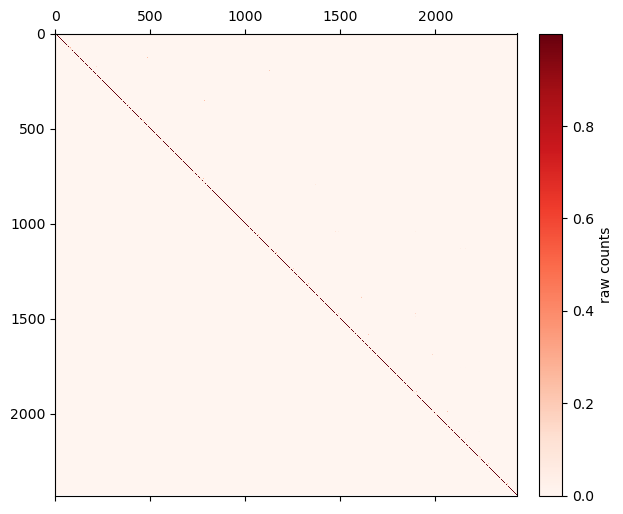

In [18]:
f, ax = plt.subplots(figsize=(7,6))
im = ax.matshow(imputation_matrix,cmap='Reds');
plt.colorbar(im ,fraction=0.046, pad=0.04, label='raw counts')